# 01: Goodfellow GAN Architecture Setup

Purpose: this notebook is the workflow to creating the `GoodfellowGan()` arthictecture for the adversarial package. Note that this is done iteratively between this notebook and within the source package `adversarial/networks.py` - this notebook serves as a mental workthrough for reference and is not intended for experimental runs and may not flow linearly. 

# Imports

In [1]:
from typing import Tuple

import os

import torch
from torch import nn
import torchvision


from adversarial.networks import (GoodfellowG,
                                  GoodfellowD,
                                  GoodfellowGAN)

# plotting
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Globals

In [2]:
# Directories
EXP_DATA = os.path.abspath(os.path.join("..", "data", "01_raw"))

directories = [EXP_DATA]

# CUDA availability    
DEVICE = torch.device(0) if torch.cuda.is_available() else 'cpu'
print(f"using {DEVICE =}")

using DEVICE ='cpu'


In [3]:
for p in directories:
    if not os.path.exists(p):
        try:
            os.makedirs(p)
        except FileExistsError:
            print("p exists and was somehow uncaught")

# Data

The torchvision MNIST dataset should be just fine. 

In [4]:
img_size = 28
ds_train = torchvision.datasets.MNIST(EXP_DATA, train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size,img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))
ds_test = torchvision.datasets.MNIST(EXP_DATA, train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size,img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [5]:
ds = torch.utils.data.Subset(ds_train, range(1024))
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

# Network

In [6]:
img_size = 28**2
latent_dim = 10
hidden_dim = 5
device = DEVICE

g_args = {"img_size": img_size, 
          "latent_dim": latent_dim,
          "hidden_dim": hidden_dim,
          "device": device}

d_args = {"img_size": img_size, 
          "latent_dim": latent_dim,
          "device": device}

g = GoodfellowG(**g_args)
d = GoodfellowD(**d_args)

gf_args = {"G": g,
           "D": d,
           "img_size": img_size, 
           "latent_dim": latent_dim,
           "hidden_dim": hidden_dim,
           "device": device}

gnet = GoodfellowGAN(**gf_args)

In [7]:
def sample_latent_space(latent_dim: int = None, batch_size: int = 32
) -> Tuple[torch.tensor, torch.tensor]:
    """Sample a normal distribution for latent space vectors

    Note, that this assumes row-based data (as expected in Pytorch).

    Args:
        latent_size ): latent space vector, size: batch_size X latent_size

    Returns:
        z, u Tuple[torch.tensor]: batch_size X img_size tensor, and list of zeros as labels
    """

    return torch.randn(batch_size, latent_dim), torch.zeros(batch_size, 1)

# Tests

In [8]:
def test_sample_latent_space(img_size:int=None, batch_size:int=None):
    z, u = sample_latent_space(img_size, batch_size)
    print(z.shape)
    assert z.shape==torch.Size([batch_size, img_size])
    assert all([val==0.0 for val in u])
    
test_sample_latent_space(batch_size=3, img_size=5)
test_sample_latent_space(batch_size=32, img_size=28)

torch.Size([3, 5])
torch.Size([32, 28])


In [9]:
def test_generator_forward(g: GoodfellowG):
    
    input_dim = g.latent_dim
    output_dim = g.img_size
    z, u = g.sample_latent_space(input_dim, batch_size=32)
    
    assert z.shape == (32, input_dim)
    
    z = g.forward(z)
    
    assert z.shape == (32, output_dim)
    
test_generator_forward(g)

# Train Network (sample)

In [10]:
optimizer=torch.optim.Adam(gnet.parameters(), lr=0.001)

In [11]:
outpath = os.path.abspath(os.path.join("..", "data", "05_models"))
if not os.path.exists(outpath):
    os.makedirs(outpath)
    print(f"made {outpath}")

In [12]:
gnet.train(dl, optimizer=optimizer, epochs=10, checkpoints=[0,5,9], path=outpath)

100%|██████████| 10/10 [00:02<00:00,  4.31it/s]


# Output Images

In [24]:
z, u = g.sample_latent_space(latent_dim, batch_size=9)
print(f"fake latent size: {z.size()}")
fake_images = g.forward(z)
print(f"fake images size: {fake_images.size()}")

fake latent size: torch.Size([9, 10])
fake images size: torch.Size([9, 784])


In [25]:
fake_images[1,:].size()

torch.Size([784])

In [26]:
# for i in range(9):  
#     plt.subplot(330 + 1 + i)
#     plt.imshow(fake_images[i:,])
#     plt.show()

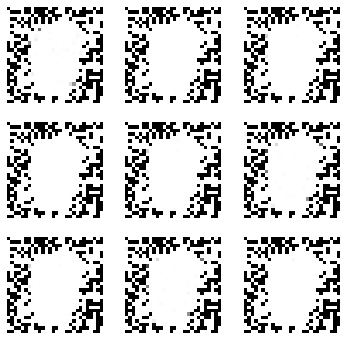

In [27]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

fig, ax = plt.subplots(figsize=(6,6), nrows=3, ncols=3)

for i in range(3):
    for j in range(3):
        img = fake_images[i+j,:]
        img = img.detach().cpu().numpy().reshape(28,28)
        ax[i,j].axis('off')
        ax[i,j].imshow(img, cmap=pyplot.get_cmap('gray'))
        

plt.show();
        

Not great, but only 10 epochs. and only 1024 images. 

# Train Network (full dataset)

In [22]:
# grab full train dataset
dl = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)

# recreate 
gnet = GoodfellowGAN(**gf_args)

# name full model checkpoints
outpath = os.path.abspath(os.path.join("..", "data", "05_models", "goodfellow-mnist-full.pt"))

# checkpoints
checkpoints = range(0, 110, 20)


In [23]:
gnet.train(dl, optimizer=optimizer, epochs=100, checkpoints=checkpoints, path=outpath)


100%|██████████| 100/100 [21:55<00:00, 13.15s/it]


# Output Images (full dataset)

In [28]:
real_sample, real_labels = next(iter(dl))
real_sample 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [29]:
real_sample.size()

torch.Size([32, 784])

In [30]:
# check that discriminator even tells real from fake at all
real_sample, _ = next(iter(dl)) 
fake_sample, _ = g.sample_latent_space(latent_dim, batch_size=32)
fake_sample = g.forward(fake_sample)

real_logits = d.forward(real_sample)
fake_logits = d.forward(fake_sample)

print(real_logits.mean())
print(fake_logits.mean())


tensor(1., grad_fn=<MeanBackward0>)
tensor(1., grad_fn=<MeanBackward0>)


In [31]:
z, u = g.sample_latent_space(latent_dim, batch_size=9)
print(f"fake latent size: {z.size()}")
fake_images = g.forward(z)
print(f"fake images size: {fake_images.size()}")

fake latent size: torch.Size([9, 10])
fake images size: torch.Size([9, 784])


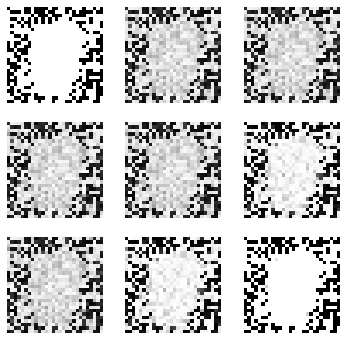

In [33]:
fig, ax = plt.subplots(figsize=(6,6), nrows=3, ncols=3)

for i in range(3):
    for j in range(3):
        img = fake_images[i+j,:]
        img = img.detach().cpu().numpy().reshape(28,28)
        ax[i,j].axis('off')
        ax[i,j].imshow(img, cmap=pyplot.get_cmap('gray'))
        

plt.show();